<a href="https://colab.research.google.com/github/umar-faroooq/PyTorch_Tutorial/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

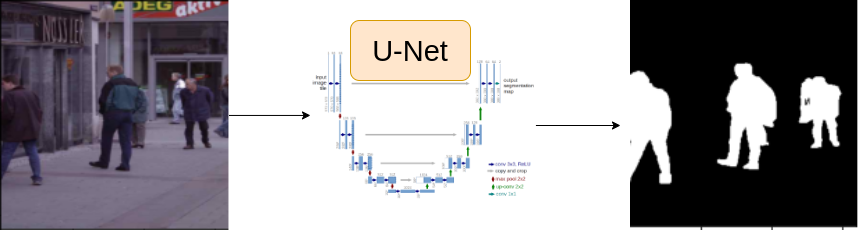

# Some Common Imports

In [6]:
!nvidia-smi

Fri Jan 27 18:12:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [7]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
ENCODER_NAME = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [14]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

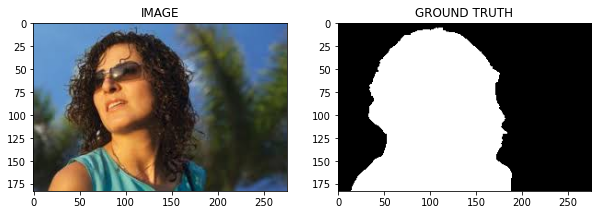

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [16]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
print(len(train_df))
print(len(valid_df))

232
58


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [19]:
import albumentations as A

In [131]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p =0.5),
      A.VerticalFlip( p = 0.5),
      # ,

  ], is_check_shapes = False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [132]:
from torch.utils.data import Dataset

In [133]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)
    
    
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) ---> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask
    

In [134]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [135]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [136]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

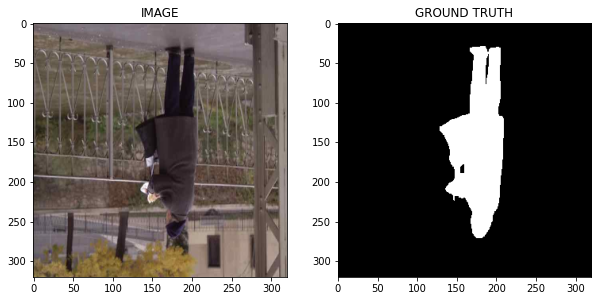

In [137]:
idx = 4

image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [138]:
from torch.utils.data import DataLoader

In [139]:
BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [140]:
print(f'Total no. of batches in trainloader {len(trainloader)}')
print(f'Total no. of batches in validloader {len(validloader)}')

Total no. of batches in trainloader 15
Total no. of batches in validloader 4


In [141]:
for image, mask in trainloader:
  break

print(f"one batc image shape : {image.shape}")
print(f"one batc image shape : {mask.shape}")

one batc image shape : torch.Size([16, 3, 320, 320])
one batc image shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [142]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [149]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER_NAME,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask=None):

    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode='binary')(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2
    return logits



In [150]:
model = SegmentationModel()
model.to(DEVICE);


# Task 7 : Create Train and Validation Function 

In [151]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()


    total_loss += loss.item()

  return total_loss / len(data_loader)



In [155]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      # optimizer.zero_grad()

      logits, loss = model(images, masks)
      # loss.backward()
      # optimizer.step()


      total_loss += loss.item()

  return total_loss / len(data_loader)



# Task 8 : Train Model

In [156]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [157]:
best_valid_loss = np.Inf
for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)


  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")

    print("SAved-MODEL")

    best_valid_loss = valid_loss


  print(f"Epoch: { i+1} Train_loss : {train_loss} Valid_Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


SAved-MODEL
Epoch: 1 Train_loss : 0.4120081345240275 Valid_Loss : 0.9179341495037079


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAved-MODEL
Epoch: 2 Train_loss : 0.316599511106809 Valid_Loss : 0.32691605389118195


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch: 3 Train_loss : 0.27370421290397645 Valid_Loss : 0.48489271849393845


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAved-MODEL
Epoch: 4 Train_loss : 0.29181725879510245 Valid_Loss : 0.2772248089313507


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


SAved-MODEL
Epoch: 5 Train_loss : 0.22989919980367024 Valid_Loss : 0.2519616521894932


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


SAved-MODEL
Epoch: 6 Train_loss : 0.21729677319526672 Valid_Loss : 0.25110331922769547


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


SAved-MODEL
Epoch: 7 Train_loss : 0.16441395580768586 Valid_Loss : 0.20874154940247536


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


SAved-MODEL
Epoch: 8 Train_loss : 0.15305098444223403 Valid_Loss : 0.1909918375313282


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch: 9 Train_loss : 0.1805915375550588 Valid_Loss : 0.19580510631203651


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch: 10 Train_loss : 0.1370449483394623 Valid_Loss : 0.22798172011971474


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch: 11 Train_loss : 0.15793171326319377 Valid_Loss : 0.20914465934038162


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Epoch: 12 Train_loss : 0.16499066203832627 Valid_Loss : 0.24248982593417168


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch: 13 Train_loss : 0.20674123167991637 Valid_Loss : 0.2456543743610382


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch: 14 Train_loss : 0.16007850766181947 Valid_Loss : 0.1931430958211422


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


SAved-MODEL
Epoch: 15 Train_loss : 0.12972542643547058 Valid_Loss : 0.15607944689691067


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch: 16 Train_loss : 0.12023824354012808 Valid_Loss : 0.17546432465314865


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch: 17 Train_loss : 0.11504176706075668 Valid_Loss : 0.2094961702823639


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch: 18 Train_loss : 0.10435360819101333 Valid_Loss : 0.18278635293245316


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch: 19 Train_loss : 0.0994999850789706 Valid_Loss : 0.16681355610489845


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 20 Train_loss : 0.08940521428982416 Valid_Loss : 0.17406615242362022


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch: 21 Train_loss : 0.0909270112713178 Valid_Loss : 0.15628022328019142


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Epoch: 22 Train_loss : 0.105499084542195 Valid_Loss : 0.18143799901008606


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 23 Train_loss : 0.08680413315693537 Valid_Loss : 0.1929163821041584


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch: 24 Train_loss : 0.09275791694720587 Valid_Loss : 0.19830037280917168


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

Epoch: 25 Train_loss : 0.10152651742100716 Valid_Loss : 0.1931324228644371


# Task 9 : Inference

In [160]:
idx = 1 

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

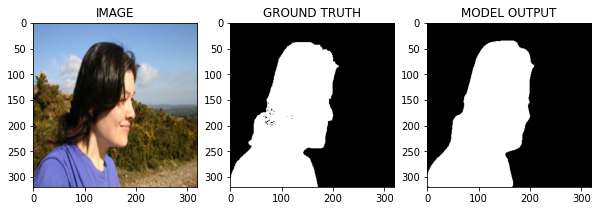

In [161]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))